In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
from scipy import optimize
import re
import copy
import logging
import sys
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import StrMethodFormatter
sns.set()

# a little hacky, but works if you don't want to actually install the
# custom packages 
sys.path.append('../')
from uniswapv3_simulator.pool import Uniswapv3Pool
from uniswapv3_simulator.utils import *
from uniswapv3_simulator.math import tick_to_sqrt_price, sqrt_price_to_tick
from utils import amount_to_float

In [2]:
POOL = 'WBTC-USDC-3000'
NUMERAIRE_TOKEN = 1
MAX_DATE = '2022-01-28'
SAVE_FREQ = 'D'  # change to 'H' if you want hourly pool snapshots
SAVED_POOLS = f'./saved-pools/{POOL}.pickle'
SAVED_DAILY_RETURNS = f'./saved-daily-returns/{POOL}.pickle'
SAVED_WEEKLY_RETURNS = f'./saved-weekly-returns/{POOL}.pickle'

timestamp = datetime.now().strftime('%y%m%d%H%M%S')
logging.basicConfig(level=logging.INFO,
                    filename=f'./logs/{POOL}_{timestamp}.log')
logging.getLogger('uniswap-v3').setLevel(logging.INFO)
logging.getLogger('uniswap-v3.utils').setLevel(logging.DEBUG)

In [3]:
data = pd.read_pickle('../data/pool_data_clean.pickle')
swaps = data[POOL]['swaps']
liquidity = data[POOL]['liquidity']

In [4]:
swaps.info()
swaps.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59869 entries, 0 to 59868
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype              
---  ------                          --------------  -----              
 0   swap_time                       59869 non-null  datetime64[ns, UTC]
 1   tx_hash                         59869 non-null  string             
 2   token_0_amount                  59869 non-null  float64            
 3   token_1_amount                  59869 non-null  float64            
 4   pool_address                    59869 non-null  string             
 5   price_tick                      59869 non-null  int64              
 6   price_tick_adjusted             59869 non-null  float64            
 7   contract_address_token_0        59869 non-null  string             
 8   contract_name_token_0           59869 non-null  string             
 9   contract_ticker_symbol_token_0  59869 non-null  string             
 10  contract_d

,swap_time,tx_hash,token_0_amount,token_1_amount,pool_address,price_tick,price_tick_adjusted,contract_address_token_0,contract_name_token_0,contract_ticker_symbol_token_0,contract_decimals_token_0,contract_address_token_1,contract_name_token_1,contract_ticker_symbol_token_1,contract_decimals_token_1,pool_fee,pool_tick_spacing,pool_deploy_time
0,2022-01-29 19:16:46+00:00,0xefb6c69ebc8f3c4fddd76285fcab762bad87f76e2711...,-3.954100,149915.227680,0x99ac8ca7087fa4a2a1fb6357269965a2014abc35,59358,37823.028503,0x2260fac5e5542a773aa44fbcfedf7c193bc2c599,Wrapped BTC,WBTC,8,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USD Coin,USDC,6,3000,60,2021-05-05 19:13:15+00:00
1,2022-01-29 19:15:23+00:00,0xb8dfaa80fc9d3eef699d82c12efe5d8af461850b7fdf...,-0.867346,32860.000005,0x99ac8ca7087fa4a2a1fb6357269965a2014abc35,59345,37773.892968,0x2260fac5e5542a773aa44fbcfedf7c193bc2c599,Wrapped BTC,WBTC,8,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USD Coin,USDC,6,3000,60,2021-05-05 19:13:15+00:00
2,2022-01-29 18:57:13+00:00,0xf425d531045993eb8d366ea67982805eba019f02e3c2...,-1.056121,40000.000000,0x99ac8ca7087fa4a2a1fb6357269965a2014abc35,59343,37766.339322,0x2260fac5e5542a773aa44fbcfedf7c193bc2c599,Wrapped BTC,WBTC,8,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USD Coin,USDC,6,3000,60,2021-05-05 19:13:15+00:00
3,2022-01-29 18:50:50+00:00,0xea8be1860e6a79044e77e7eadaeddfacebd518a878a5...,-5.947671,225024.000000,0x99ac8ca7087fa4a2a1fb6357269965a2014abc35,59339,37751.236563,0x2260fac5e5542a773aa44fbcfedf7c193bc2c599,Wrapped BTC,WBTC,8,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USD Coin,USDC,6,3000,60,2021-05-05 19:13:15+00:00
4,2022-01-29 18:23:26+00:00,0x74080f03033e03f829265b4943338886d4f6f85c0bf5...,-0.072087,2724.828817,0x99ac8ca7087fa4a2a1fb6357269965a2014abc35,59321,37683.348848,0x2260fac5e5542a773aa44fbcfedf7c193bc2c599,Wrapped BTC,WBTC,8,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USD Coin,USDC,6,3000,60,2021-05-05 19:13:15+00:00


In [5]:
liquidity.info()
liquidity.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10876 entries, 0 to 10875
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype              
---  ------                          --------------  -----              
 0   txn_time                        10876 non-null  datetime64[ns, UTC]
 1   tx_hash                         10876 non-null  string             
 2   token_0_amount                  10876 non-null  float64            
 3   token_1_amount                  10876 non-null  float64            
 4   pool_address                    10876 non-null  string             
 5   liquidity_event                 10876 non-null  string             
 6   price_tick_lower                10876 non-null  int64              
 7   price_tick_upper                10876 non-null  int64              
 8   price_tick_lower_adjusted       10876 non-null  float64            
 9   price_tick_upper_adjusted       10876 non-null  float64            
 10  contract_a

,txn_time,tx_hash,token_0_amount,token_1_amount,pool_address,liquidity_event,price_tick_lower,price_tick_upper,price_tick_lower_adjusted,price_tick_upper_adjusted,...,contract_address_token_1,contract_name_token_1,contract_ticker_symbol_token_1,contract_decimals_token_1,event_name,account_address,pool_fee,pool_tick_spacing,pool_deploy_time,liquidity
0,2022-01-29 14:34:45+00:00,0x5574ae4a7e7eca2d2a9b46d9f8d1dd249a7b149443b1...,0.000000,0.000000e+00,0x99ac8ca7087fa4a2a1fb6357269965a2014abc35,REMOVE_LIQUIDITY,58380,60660,34299.234168,43082.273604,...,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USD Coin,USDC,6,Burn,0x7c3d434d79dddac3174ce0819f55ed82e0276147,3000,60,2021-05-05 19:13:15+00:00,-0.000000e+00
1,2022-01-29 14:34:45+00:00,0x5574ae4a7e7eca2d2a9b46d9f8d1dd249a7b149443b1...,0.000000,0.000000e+00,0x99ac8ca7087fa4a2a1fb6357269965a2014abc35,REMOVE_LIQUIDITY,58380,59520,34299.234168,38440.720478,...,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USD Coin,USDC,6,Burn,0x7c3d434d79dddac3174ce0819f55ed82e0276147,3000,60,2021-05-05 19:13:15+00:00,-0.000000e+00
2,2022-01-29 11:49:52+00:00,0x10e9d01f3880655734f19a9926ea6c7309d7705e954a...,0.013782,4.999998e+02,0x99ac8ca7087fa4a2a1fb6357269965a2014abc35,ADD_LIQUIDITY,54060,64800,22267.865384,65175.975598,...,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USD Coin,USDC,6,Mint,0xb8803d0421f27c3c7e146abc604da9d4b5b240de,3000,60,2021-05-05 19:13:15+00:00,1.115092e-10
3,2022-01-29 10:14:33+00:00,0x97118fcde8fa493dba2c63fe983f990c40998a4d61b0...,82.654222,1.481778e+06,0x99ac8ca7087fa4a2a1fb6357269965a2014abc35,ADD_LIQUIDITY,58020,62160,33086.482866,50054.085346,...,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USD Coin,USDC,6,Mint,0x888e1b67bfb11d6a68c43a6af939b89d8defb2bb,3000,60,2021-05-05 19:13:15+00:00,1.212369e-06
4,2022-01-29 05:59:07+00:00,0xefb7032971be18fdaa23b7bc732fcffbcf3a72e06160...,29.276980,1.431584e+06,0x99ac8ca7087fa4a2a1fb6357269965a2014abc35,REMOVE_LIQUIDITY,55200,62460,24956.615202,51578.381825,...,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USD Coin,USDC,6,Burn,0x04c82c5791bbbdfbdda3e836ccbef567fdb2ea07,3000,60,2021-05-05 19:13:15+00:00,-3.939689e-07


In [6]:
# looks like liquidity for this pool uses 8 decimal places rather than 18
liquidity['liquidity'] = liquidity['liquidity'] * 1e+10

In [7]:
adds = liquidity.loc[liquidity['liquidity_event'] == 'ADD_LIQUIDITY', :].copy()
adds = adds.sort_values('txn_time').reset_index(drop=True)
adds.head()

,txn_time,tx_hash,token_0_amount,token_1_amount,pool_address,liquidity_event,price_tick_lower,price_tick_upper,price_tick_lower_adjusted,price_tick_upper_adjusted,...,contract_address_token_1,contract_name_token_1,contract_ticker_symbol_token_1,contract_decimals_token_1,event_name,account_address,pool_fee,pool_tick_spacing,pool_deploy_time,liquidity
0,2021-05-05 19:13:15+00:00,0x2acb44ed240131e3a05eacc0ee870bdf93564f299eb6...,0.011928,7.241840e+02,0x99ac8ca7087fa4a2a1fb6357269965a2014abc35,ADD_LIQUIDITY,62160,64800,50054.085346,65175.975598,...,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USD Coin,USDC,6,Mint,0x3c92e144062297cfd08a5a9baab59aaabd3231f3,3000,60,2021-05-05 19:13:15+00:00,4.603874
1,2021-05-05 21:06:32+00:00,0x602034e50383895947441bf36b1c09784c333e1ff67f...,74.367447,4.219059e+06,0x99ac8ca7087fa4a2a1fb6357269965a2014abc35,ADD_LIQUIDITY,59940,67140,40089.530963,82358.299055,...,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USD Coin,USDC,6,Mint,0x8d89eda15d91ad6bc96c42bbedabfd3f2e16fca8,3000,60,2021-05-05 19:13:15+00:00,10753.609507
2,2021-05-05 21:24:47+00:00,0xf63a954ff144da57e15c339fab9a37656cddf09a424b...,66.280753,3.743677e+06,0x99ac8ca7087fa4a2a1fb6357269965a2014abc35,ADD_LIQUIDITY,55200,71940,24956.615202,133093.944831,...,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USD Coin,USDC,6,Mint,0xd6804f11e1ca917df003127c7ed51dba5da6bf8b,3000,60,2021-05-05 19:13:15+00:00,4606.710099
3,2021-05-05 22:47:55+00:00,0x3956908e039c4ca68d573678d3842bf7729f182daf05...,0.098023,3.942920e+03,0x99ac8ca7087fa4a2a1fb6357269965a2014abc35,ADD_LIQUIDITY,61200,66840,45472.553647,79924.363347,...,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USD Coin,USDC,6,Mint,0x41d973acb9fe351e5b14d08aebee6c13abc17cab,3000,60,2021-05-05 19:13:15+00:00,15.216602
4,2021-05-05 22:53:01+00:00,0xc7d78c39089f8bed2286a64ad6e09774d5f70af9aa14...,0.013167,7.156860e+02,0x99ac8ca7087fa4a2a1fb6357269965a2014abc35,ADD_LIQUIDITY,62340,64800,50963.170653,65175.975598,...,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USD Coin,USDC,6,Mint,0x8a67d51dd792f40b48af62d36683552215a79088,3000,60,2021-05-05 19:13:15+00:00,5.148812


In [8]:
first_add_hash = adds.at[0, 'tx_hash']
print(f'First liquidity add hash: {first_add_hash}')

First liquidity add hash: 0x2acb44ed240131e3a05eacc0ee870bdf93564f299eb633156a60d81055a352eb


In [9]:
# from https://etherscan.io/tx/0x2acb44ed240131e3a05eacc0ee870bdf93564f299eb633156a60d81055a352eb#eventlog
liquidity_delta = amount_to_float('460387401', 8)  # this pool uses 8 decimals for liquidity (adjusted above)
assert liquidity_delta == adds.at[0, 'liquidity']

token0 = adds.at[0, 'token_0_amount']
token1 = adds.at[0, 'token_1_amount']
tick_lower = adds.at[0, 'price_tick_lower']
tick_upper = adds.at[0, 'price_tick_upper']
token0_decimals = adds.at[0, 'contract_decimals_token_0']
token1_decimals = adds.at[0, 'contract_decimals_token_1']

init_price = pool_init_price(token0, token1, tick_upper, tick_lower, liquidity_delta,
                             token0_decimals, token1_decimals)

token0_symb = liquidity.at[0, 'contract_ticker_symbol_token_0']
token1_symb = liquidity.at[0, 'contract_ticker_symbol_token_1']
print(f'Pool initial price ({token1_symb}/{token0_symb}): {init_price:,.12e}')
print(f'Pool initial price ({token0_symb}/{token1_symb}): {1 / init_price:,.12e}')

Pool initial price (USDC/WBTC): 5.733993536946e+02
Pool initial price (WBTC/USDC): 1.743985223486e-03


In [10]:
sqrt_price_x96 = 1897178451720590875109406646877
etherscan_price = sqrt_price_x96 ** 2 / 2 ** 192
print(f"Calculated initial price: {init_price:.12e}")
print(f"Price per Etherscan:      {etherscan_price:.12e}")

Calculated initial price: 5.733993536946e+02
Price per Etherscan:      5.733993536192e+02


In [11]:
all_txn = organize_txns(liquidity, swaps, max_date=MAX_DATE)
all_txn

,orig_idx,tx_hash,txn_time,event
0,10875,0x2acb44ed240131e3a05eacc0ee870bdf93564f299eb6...,2021-05-05 19:13:15+00:00,ADD_LIQUIDITY
1,10874,0x602034e50383895947441bf36b1c09784c333e1ff67f...,2021-05-05 21:06:32+00:00,ADD_LIQUIDITY
2,59868,0xf50dd2ad40e841f3a75dbe9bd113a0beb457e9c60ae2...,2021-05-05 21:08:03+00:00,SWAP
3,59867,0xc6e7241ce2254b9082f1c89a335be138d3d55c526d8e...,2021-05-05 21:08:23+00:00,SWAP
4,59866,0xddd29d5a777047bb81c5824450b04bef9a18e96df1f2...,2021-05-05 21:12:44+00:00,SWAP
...,...,...,...,...
70472,262,0x9dcb82483c60afbc11cb9a08a109b8e36bea6c0eb9c2...,2022-01-27 23:31:25+00:00,SWAP
70473,261,0x3c719b85571c54b1172fdf64ea9b5a2366a06c6eace1...,2022-01-27 23:32:31+00:00,SWAP
70474,260,0x4e1e094c760ed85cfc9b4338b8813ad6de56a4d437a1...,2022-01-27 23:45:57+00:00,SWAP
70475,259,0xf702963243984842e1e8fa6f44c831298d894faef449...,2022-01-27 23:53:43+00:00,SWAP


In [12]:
CHECKS_ON = False
# need to think about appropriate error tolerances
# TODO: maybe base these tolerances on the average transaction size?
TOKEN0_TOLS = {'atol': 1e-8, 'rtol': 1e-5}
TOKEN1_TOLS = {'atol': 1e-8, 'rtol': 1e-5}
LIQUIDITY_TOLS = {'atol': 1e-8, 'rtol': 1e-5}

In [ ]:
pool_snapshots, tx_results = run_historical_pool(
    init_price, 
    all_txn, 
    liquidity, 
    swaps,
    save_freq=SAVE_FREQ,
    position_id='generic_LP', 
    checks_on=CHECKS_ON, 
    verbose=True,
    token0_tols=TOKEN0_TOLS,
    token1_tols=TOKEN1_TOLS,
    liquidity_tols=LIQUIDITY_TOLS
)
pd.to_pickle(pool_snapshots, SAVED_POOLS)

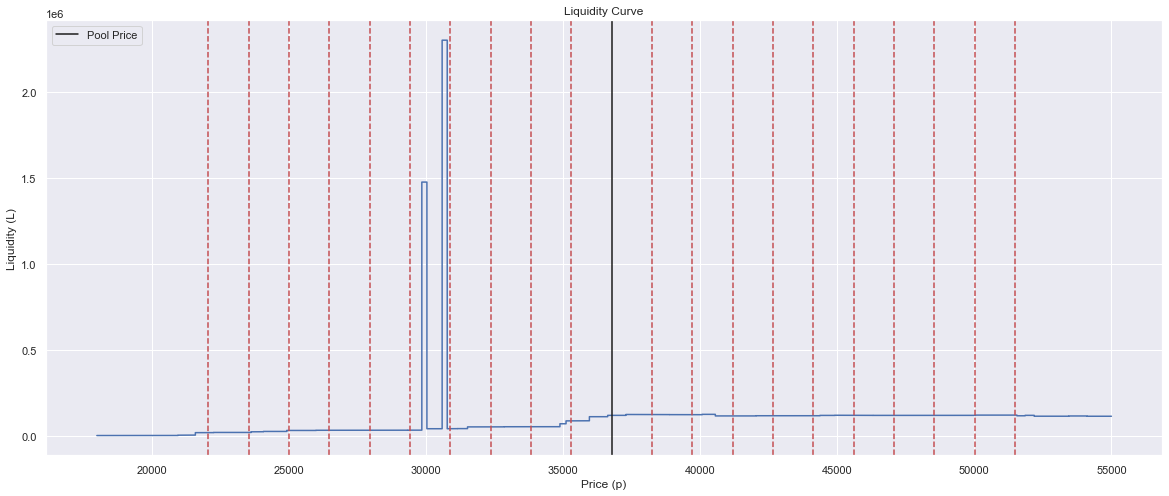

In [18]:
example_day = '2022-01-27 00:00:00'
sigma = 0.04
pool = pool_snapshots[example_day]
price_bins = np.array(
    [0]
    + [pool.price * (1 + i * sigma) for i in range(-10, 11)]
    + [np.inf]
)

fig, ax = plt.subplots(figsize=(20, 8))
pool.plot_liquidity_curve(interval=(20000, 50000), ax=ax)

for price in price_bins[1:-1]:
    if price == pool.price:
        ax.axvline(price, color='k', label='Pool Price')
    else:
        ax.axvline(price, color='r', linestyle='--')
ax.legend(loc='upper left')

plt.show()

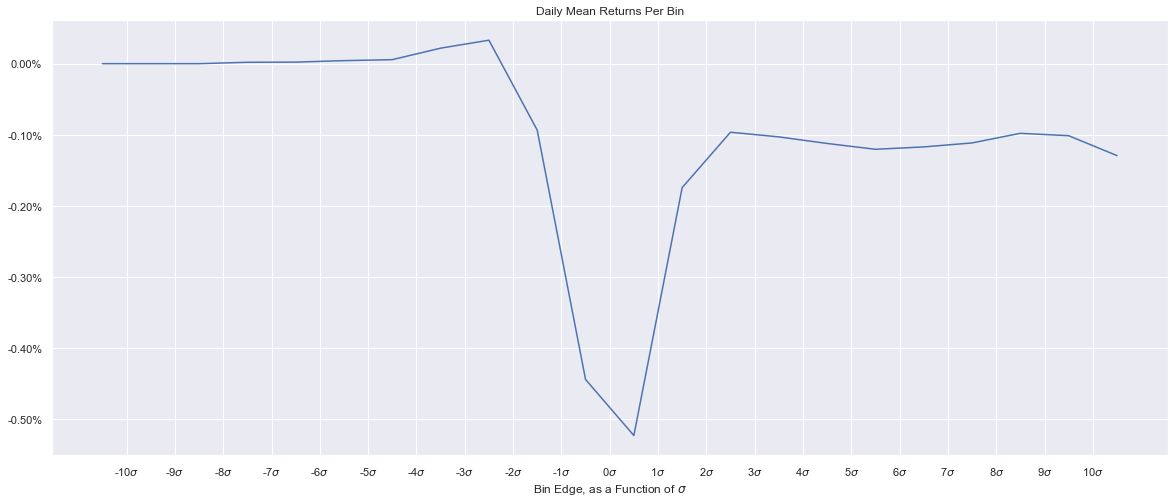

CPU times: user 1min 57s, sys: 3.68 s, total: 2min 1s
Wall time: 2min 3s


In [15]:
%%time
# daily returns
all_returns = calc_all_returns_per_bin(
    pool_snapshots, 
    all_txn, 
    liquidity, 
    swaps,
    freq='D',  # pandas frequency codes (can also include anchor)
    sigma=0.04, 
    numeraire_token=NUMERAIRE_TOKEN
)
pd.to_pickle(all_returns, SAVED_DAILY_RETURNS)
   
bin_returns = defaultdict(list)
for day, irrs in all_returns.items():
    for bin_pos, irr in irrs.items():
        bin_no = int(re.findall(r'_bin(\d+)_', bin_pos)[0])
        bin_returns[bin_no].append(irr)
        
fig, ax = plt.subplots(figsize=(20, 8))

x_pos, x_labels, y = [], [], []
for i in range(1, 23):
    x_pos.append(i)
    x_labels.append(f'{i - 11}$\sigma$')
    y.append(np.mean(bin_returns[i]))
ax.plot(x_pos, y)

ax.set_xticks(ticks=np.array(x_pos[:-1]) + 0.5, labels=x_labels[:-1])
ax.set_title('Daily Mean Returns Per Bin')
ax.set_xlabel('Bin Edge, as a Function of $\sigma$')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.2%}'))

plt.show()

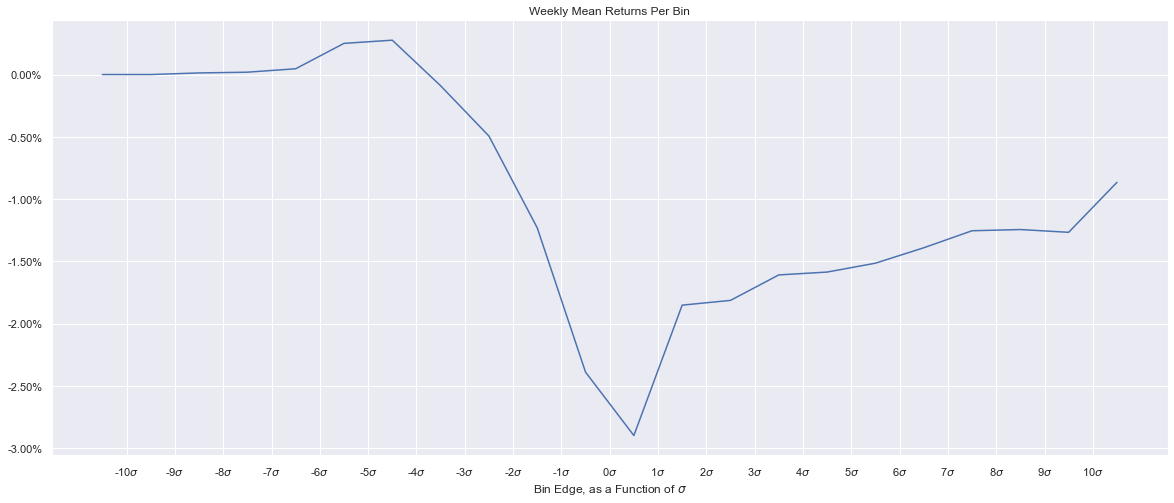

CPU times: user 37.3 s, sys: 1.29 s, total: 38.6 s
Wall time: 39 s


In [16]:
%%time
# weekly returns
all_returns = calc_all_returns_per_bin(
    pool_snapshots, 
    all_txn, 
    liquidity, 
    swaps,
    freq='W',  # pandas frequency codes (can also include anchor)
    sigma=0.04, 
    numeraire_token=NUMERAIRE_TOKEN
)
pd.to_pickle(all_returns, SAVED_WEEKLY_RETURNS)
   
bin_returns = defaultdict(list)
for day, irrs in all_returns.items():
    for bin_pos, irr in irrs.items():
        bin_no = int(re.findall(r'_bin(\d+)_', bin_pos)[0])
        bin_returns[bin_no].append(irr)
        
fig, ax = plt.subplots(figsize=(20, 8))

x_pos, x_labels, y = [], [], []
for i in range(1, 23):
    x_pos.append(i)
    x_labels.append(f'{i - 11}$\sigma$')
    y.append(np.mean(bin_returns[i]))
ax.plot(x_pos, y)

ax.set_xticks(ticks=np.array(x_pos[:-1]) + 0.5, labels=x_labels[:-1])
ax.set_title('Weekly Mean Returns Per Bin')
ax.set_xlabel('Bin Edge, as a Function of $\sigma$')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.2%}'))

plt.show()

In [17]:
# %%time
# # hourly returns
# all_returns = calc_all_returns_per_bin(
#     pool_snapshots, 
#     all_txn, 
#     liquidity, 
#     swaps,
#     freq='H',  # pandas frequency codes (can also include anchor)
#     sigma=0.005,  # reducing this for this test
#     numeraire_token=NUMERAIRE_TOKEN
# )
# # pd.to_pickle(all_returns, SAVED_WEEKLY_RETURNS) NOT SAVING THIS ONE FOR NOW!
   
# bin_returns = defaultdict(list)
# for day, irrs in all_returns.items():
#     for bin_pos, irr in irrs.items():
#         bin_no = int(re.findall(r'_bin(\d+)_', bin_pos)[0])
#         bin_returns[bin_no].append(irr)
        
# fig, ax = plt.subplots(figsize=(20, 8))

# x_pos, x_labels, y = [], [], []
# for i in range(1, 23):
#     x_pos.append(i)
#     x_labels.append(f'{i - 11}$\sigma$')
#     y.append(np.mean(bin_returns[i]))
# ax.plot(x_pos, y)

# ax.set_xticks(ticks=np.array(x_pos[:-1]) + 0.5, labels=x_labels[:-1])
# ax.set_title('Hourly Mean Returns Per Bin')
# ax.set_xlabel('Bin Edge, as a Function of $\sigma$')
# ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.2%}'))

# plt.show()